<a href="https://colab.research.google.com/github/LukeSchmitt96/gym-pybullet-drones/blob/master/tether_sim/DQN_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/LukeSchmitt96/gym-pybullet-drones

In [ ]:
pip install gym

In [ ]:
pip install pybullet

In [ ]:
pip install stable-baselines3

In [ ]:
pip install 'ray[rllib]'

In [ ]:
cd gym-pybullet-drones/

In [ ]:
pip install -e .

[INFO] BaseAviary.__init__() loaded parameters from the drone's .urdf:
[INFO] m 0.027000, L 0.039700,
[INFO] ixx 0.000014, iyy 0.000014, izz 0.000022,
[INFO] kf 0.000000, km 0.000000,
[INFO] t2w 2.250000, max_speed_kmh 30.000000,
[INFO] gnd_eff_coeff 11.368590, prop_radius 0.023135,
[INFO] drag_xy_coeff 0.000001, drag_z_coeff 0.000001,
[INFO] dw_coeff_1 2267.180000, dw_coeff_2 0.160000, dw_coeff_3 -0.110000
plugin= 4
[INFO] Max tether force set to  0.7144 N


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


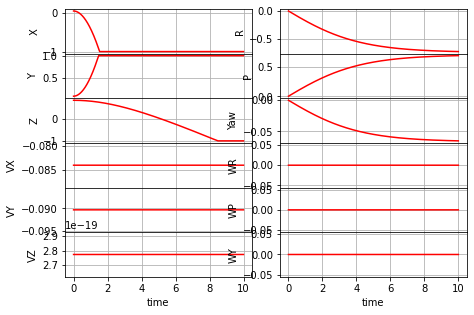

In [9]:
#!/usr/bin/env python

import os
import time
import pdb
import math
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding

import keras, tensorflow as tf, numpy as np, gym, sys, copy, argparse
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import model_from_json
import collections
import matplotlib.pyplot as plt
import random

from gym_pybullet_drones.envs.RLTetherAviary import RLTetherAviary

from gym_pybullet_drones.utils.Logger import Logger

# from gym_pybullet_drones.envs.RLCrazyFlieAviary import RLCrazyFlieAviary

class DQN():

	def __init__(self, environment):
		
		self.environment = environment
		self.num_actions = self.environment.action_space.shape[0] # Pitch forward, Pitch backward, Roll left, Roll right, Hover
		self.state_size = self.environment.reset().shape[0]
		self.model = Sequential()
		self.model.add(Dense(128, input_dim=self.state_size, activation = 'relu')) # Define number of layers, neurons and activation
		self.model.add(Dense(64, activation = 'relu')) # Define number of layers, neurons and activation
		self.model.add(Dense(32, activation = 'relu')) # Define number of layers, neurons and activation
		self.model.add(Dense(self.num_actions))
		self.model.compile(loss = 'mse', optimizer = Adam(lr = 0.001)) # Define loss and learning rate

	def save_model_weights(self):
		
		model_json = self.model.to_json()
		with open("model.json", "w") as json_file:
			json_file.write(model_json)
		self.model.save_weights("model.h5")

	def load_model(self, model_file):
		
		json_file = open('model.json', 'r')
		loaded_model_json = json_file.read()
		json_file.close()
		self.model = model_from_json(loaded_model_json)

	def load_model_weights(self, weight_file):
		
		self.model.load_weights("model.h5")


class Replay_Memory():

	def __init__(self, memory_size = 50000): # Define replay memory size
		
	 	self.memory = collections.deque(maxlen = memory_size)

	def sample_batch(self, batch_size = 32): # Define batch size
		
		if len(self.memory) < batch_size:
			return None
		else:
			return random.sample(self.memory, batch_size)

	def append(self, transition):
		
		self.memory.append(transition)

class DQN_Agent():

	def __init__(self, environment_name):

		# self.environment_name = environment_name
		self.env = environment_name # gym.envs.make(self.environment_name)
		self.train_network = DQN(self.env)
		self.target_network = DQN(self.env)
		self.target_network.model.set_weights(self.train_network.model.get_weights())
		self.memory = Replay_Memory()
		self.num_episodes = 1500 # Define number of episodes
		self.gamma = 0.99 # Define discount rate
		self.eps_limit = 0.5 # Define Epsilon
		self.target_update = 5 # Define target net update frequency
		self.max_tether_force = self.env.MAX_TETHER_FORCE
		self.tether_length = self.env.TETHER_MIN_LENGTH

	def index_to_array(self, index, state):

		# Hover RPM = 14468 Max RPM = 21702 Tether Length = 0.2 Max Tether Force = 0.7144
		# Hover / Max = 0.66
		distance = np.linalg.norm(state[0:3])
		if distance > self.tether_length:
			tether_force = 0.66 + (np.absolute(distance - self.tether_length) / distance) # Define max tether force
		else:
			tether_force = 0 

		# Set 1
		min = 0.62 # Define RPM
		max = 0.70 # Define RPM

		# Set 2
		# min = 0.52 # Define RPM
		# max = 0.80 # Define RPM

		# Set 3
		# min = 0.42 # Define RPM
		# max = 0.90 # Define RPM
		
		hov = 0 # Define Hover RPM

		if index == 0:
			action_array = np.array([min, min, max, max, tether_force]) # Rotor 3 and Rotor 4, X-axis
		elif index == 1:
			action_array = np.array([max, max, min, min, tether_force]) # Rotor 1 and Rotor 2, X-axis
		elif index == 2:
			action_array = np.array([max, min, max, min, tether_force]) # Rotor 1 and Rotor 3, Y-axis
		elif index == 3:
			action_array = np.array([min, max, min, max, tether_force]) # Rotor 2 and Rotor 4, Y-axis
		elif index == 4:
			action_array = np.array([hov, hov, hov, hov, 0]) # Hover
		
		return action_array

	def epsilon_greedy_policy(self, q_values,state):
		
		eps = np.random.random(1)[0]
		if eps < self.eps_limit:
			action_index = np.random.randint(0, self.train_network.num_actions)
	
		else:
			action_index = np.argmax(q_values)
		
		action = self.index_to_array(action_index, state)

		current_q = q_values[action_index]
		
		return action_index, action, current_q

	def greedy_policy(self, q_values):
		
		action = np.argmax(q_values)

		return action
	
	def update_model(self):
	
		states = []
		obs_states = []
		batch = self.memory.sample_batch()

		if batch == None:
			return
		
		else:
			for tup in batch:
				state, action_index, reward, obs, done = tup
				states.append(state)
				obs_states.append(obs)
			
			states = np.asarray(states)
			obs_states = np.asarray(obs_states)

			target_q = (self.train_network.model.predict(states))
			target_q_obs = (self.target_network.model.predict(obs_states))
				
			i = 0	
			for tup in batch:
				state, action_index, reward, obs, done = tup
				if done:
					target_q[i][action_index] = reward
				else:
					q_s = max(target_q_obs[i])
					target_q[i][action_index] = reward + q_s * self.gamma
				i += 1

			self.train_network.model.train_on_batch(states, target_q) ##### Backprop qvalues

	def train(self):
		
		self.test_list = []
		self.train_td = []
		self.reward_plot = []
		episode = 0
		while episode < self.num_episodes:
			done = False
			state = self.env.reset()
			episode_td = []
			episode_reward = 0
			while not done:
				q_values = (self.train_network.model.predict(state[None, :]))[0]
				action_index, action, q = self.epsilon_greedy_policy(q_values, state)
				obs, reward, done,  _ = self.env.step(action)
				episode_reward += reward
				
				td_step = abs(reward + self.gamma * np.max((self.target_network.model.predict(obs[None, :]))) - q)
				episode_td.append(td_step)
				self.memory.append((state, action_index, reward, obs, done))
				self.update_model()
				state = obs

			self.train_td.append(np.mean(np.array(episode_td)))
			self.reward_plot.append(episode_reward)

			print('Episode: ', episode)
			print('Current Train Reward: ', episode_reward)
			print('Current TD Error: ', self.train_td[-1])
			print('\n')

			if episode % self.target_update == 0:
				self.target_network.model.set_weights(self.train_network.model.get_weights())
			
			if episode > 50:
				self.eps_limit = max(self.eps_limit - 0.005, 0.01) # Define exploration decay rate
			
			if episode % 100 == 0: 
				self.train_network.save_model_weights()
			
			if episode % 100 == 0: 
				current_test_reward = self.test(20)
				self.test_list.append(current_test_reward)
				print('Current Test Reward: ', current_test_reward)
				np.savetxt('td_error.txt', self.train_td)
				np.savetxt('test_list.txt', self.test_list)
				
				if current_test_reward >= 10000: 
					print('Problem solved!')
					self.train_network.save_model_weights()
					
					self.num_episodes = episode + 2

			episode += 1
		
		self.test_reward = self.test_list
		
		np.savetxt('td.txt', self.train_td)
		np.savetxt('reward.txt', self.test_reward)
		plt.figure(figsize = (12, 8))
		plt.plot(np.arange(len(self.test_reward)) * 100, np.ones(len(self.test_reward)) * 200, label = 'Target reward')
		plt.plot(np.arange(len(self.test_reward)) * 100, self.test_reward, label = 'Mean reward')
		plt.grid()
		plt.xlabel('Number of episodes', fontsize = 18)
		plt.ylabel('Cumulative reward', fontsize = 18)
		plt.legend(fontsize = 18)
		plt.show()
		
		plt.figure(figsize = (12, 8))
		plt.plot(np.arange(len(self.train_td)) * 100, self.train_td, label = 'Train TD Error')
		plt.grid()
		plt.xlabel('Number of Training Episodes', fontsize = 18)
		plt.ylabel('Average TD Error', fontsize = 18)
		plt.legend(fontsize = 18)
		plt.show()
	
		plt.figure(figsize = (12, 8))
		plt.plot(self.reward_plot, label = 'Train TD Error')
		plt.xlabel('Number of Training Episodes', fontsize = 18)
		plt.ylabel('Episode Rewards', fontsize = 18)
		plt.show()

	def test(self, episodes):
		
		test_reward = []
		for i in range(episodes):
			done = False
			state = self.env.reset()
			episode_reward = 0
			while not done:
				action_index = np.argmax(self.target_network.model.predict(state[None, :]))
				action = self.index_to_array(action_index, state)
				obs, reward, done, _ = self.env.step(action)
				episode_reward += reward
				state = obs
			test_reward.append(episode_reward)

		return np.mean(test_reward)

def main():

		MODEL = DQN_Agent(RLTetherAviary(gui = 0, record = 0))
		logger = Logger(logging_freq_hz=int(MODEL.env.SIM_FREQ), num_drones=1)

		MODEL.train_network.load_model('model.json')
		MODEL.train_network.load_model_weights('model.h5')
		MODEL.train_network.model.compile(loss = 'mse', optimizer = Adam(lr = 0.001))
		# state = np.array([-0.19733, -0.04503, 1, -0.02305, -0.08587, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1])
		state = np.array([0.16724, 0.02694, 1, -0.02703, -0.03411, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1])

		state = MODEL.env.reset()

		np.random.seed(1)

	# done = False

		for i in range(10 * MODEL.env.SIM_FREQ):
			q_values = (MODEL.train_network.model.predict(state[None, :]))[0]
			action_index = np.argmax(q_values)
			action = MODEL.index_to_array(action_index, state)
			obs, _, _,  _ = MODEL.env.step(action)
			logger.log(drone = 0, timestamp = 1 / MODEL.env.SIM_FREQ, state = obs)

		MODEL.env.close()
		logger.save()
		logger.plot()
    # MODEL.train()
	
if __name__ == '__main__':
	main()